In [1]:
from dataclasses import dataclass
import os
from collections import Counter

import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from imblearn.over_sampling import SMOTE
# from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import optuna
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [2]:
# Config

@dataclass
class Config:
  epochs: int = 1000
  batch_size: int = 32
  dropout_p: float = 0
  lr: float = 1e-3
  weight_decay: float = 1e-2

In [3]:
# Function to return a Dataset object from a dataset path

def load_landmark_csv(filepath, use_smote=False):
    # Hardcoded label to index mapping
    label_to_index = {
      "anger": 0,
      "disgust": 1,
      "fear": 2,
      "happy": 3,
      "sadness": 4,
      "surprise": 5,
      "contempt": 6,
    }

    # Load the CSV
    df = pd.read_csv(filepath)

    # Extract features (exclude image_name and emotion)
    feature_cols = df.columns[1:-1]
    # features = torch.tensor(df[feature_cols].values, dtype=torch.float32)
    features = df[feature_cols].values

    # Map emotion labels to class indices
    labels = df["emotion"].map(label_to_index).values
    # labels = torch.tensor(labels, dtype=torch.long)

    # Use SMOTE to balance the train set
    if use_smote:
      smote = SMOTE()
      features, labels = smote.fit_resample(features, labels)

      # print(f"After SMOTE, the train set contains: {dict(Counter(int(label) for label in labels))}")

    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    dataset = TensorDataset(features, labels)
    return dataset

In [4]:
# Get the dataset paths

# Running on Colab
# drive.mount('/content/drive')
# dataset_path = "/content/drive/My Drive/Colab Notebooks/CK+ Dataset/"

# Running locally
dataset_path = os.path.join("..", "CK+ Dataset")

# Define the Train, Validation, and Test paths
train_path = os.path.join(dataset_path, "features_train.csv")
val_path = os.path.join(dataset_path, "features_val.csv")
test_path = os.path.join(dataset_path, "features_test.csv")

# Print the Train, Validation, and Test paths
print(f"Train Path: {train_path}")
print(f"Validation Path: {val_path}")
print(f"Test Path: {test_path}")

Train Path: ../CK+ Dataset/features_train.csv
Validation Path: ../CK+ Dataset/features_val.csv
Test Path: ../CK+ Dataset/features_test.csv


In [5]:
# Create DataLoaders for Train, Validation, and Test splits

def create_loaders(batch_size):
  # Create the trainloader from the Train split
  trainset = load_landmark_csv(train_path, use_smote=True)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  # Create the valloader from the Validation split
  valset = load_landmark_csv(val_path)
  valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  # Create the testloader from the Test split
  testset = load_landmark_csv(test_path)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
  return trainloader, valloader, testloader

In [6]:
# Function to build an MLP model

# def build_mlp(config):
def build_mlp(config, layers):

    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.mlp = nn.Sequential()
            for i, (input_dim, output_dim) in enumerate(layers[:-1]):
                self.mlp.add_module(f"fc{i+1}", nn.Linear(input_dim, output_dim))
                self.mlp.add_module(f"relu{i+1}", nn.ReLU())
                self.mlp.add_module(f"dropout{i+1}", nn.Dropout(p=config.dropout_p))
            input_dim, output_dim = layers[-1]
            self.mlp.add_module(f"fc_final", nn.Linear(input_dim, output_dim))      

        def forward(self, x):
            return self.mlp(x)
    
    return MLP()

In [ ]:
# Train the model

def train(mlp, epochs, trainloader, valloader, criterion, optimizer, optuna=False):
  print(f"Training for {epochs} epochs...")
  progress_bar = None
  train_losses = []
  val_losses = []
  for epoch in range(epochs):  # loop over the dataset multiple times
      if progress_bar is None:
        progress_bar = tqdm(total=100,
                            unit=" Epochs",
                            desc=f"Epochs {epoch}-{epoch+100}")
      mlp.train()
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          features, labels = data
          features, labels = features.to(device), labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = mlp(features)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      progress_bar.update(1)

      if epoch % 100 == 99:
        progress_bar = None
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Loss: {avg_loss:.4f}")

        mlp.eval()
        min_val_loss = float('inf')
        with torch.no_grad():
            running_val_loss = 0.0
            for val_features, val_labels in valloader:
              val_features, val_labels = val_features.to(device), val_labels.to(device)
              val_outputs = mlp(val_features)
              val_loss = criterion(val_outputs, val_labels).item()
              running_val_loss += val_loss
              if val_loss < min_val_loss:
                  min_val_loss = val_loss # update best val loss
            avg_val_loss = running_val_loss / len(valloader)
            val_losses.append(avg_val_loss)
      
  print("Finished Training")
  print(f"\n------------------------------------------------------------------------------\n")

  if not optuna:
    x_vals = list(range(100, epochs + 1, 100))
    plt.plot(x_vals,
             train_losses,
             label="Train Loss",
             color="#00ffd0")
    plt.plot(x_vals,
             val_losses,
             label="Validation Loss",
             color="#ff00e3")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(f"Loss_Curve.png")

  return min_val_loss

In [8]:
def eval(mlp, testloader, criterion, optimizer):
    # Define class names and label indices
    class_names = ["Anger", "Disgust", "Fear", "Happiness", "Sadness", "Surprise", "Contempt"]
    label_order = list(range(len(class_names)))  # Create a list of indices for all classes

    print("Evaluating on the test set...")
    mlp.eval()
    running_test_loss = 0.0
    all_preds = []
    all_labels = []

    # No gradient calculation during evaluation
    with torch.no_grad():
        for test_features, test_labels in testloader:
            test_features, test_labels = test_features.to(device), test_labels.to(device)
            test_outputs = mlp(test_features)
            test_loss = criterion(test_outputs, test_labels)
            running_test_loss += test_loss.item()

            # Get predicted class indices (max value along the classes dimension)
            preds = torch.argmax(test_outputs, dim=1)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())

    # Compute average test loss
    avg_test_loss = running_test_loss / len(testloader)
    print(f"Test Loss: {avg_test_loss:.4f}")

    # Compute and display confusion matrix with fixed class labels order
    cm = confusion_matrix(all_labels, all_preds, labels=label_order)

    # Create and display confusion matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='magma', xticks_rotation=45)
    plt.title("Confusion Matrix")
    # plt.show()
    plt.savefig("Confusion_Matrix.png")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

In [21]:
# objective function for Optuna

def objective(trial):
    epochs = 1000

    dropout_p = trial.suggest_float('dropout_p', 0, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    n_layers = trial.suggest_int('n_layers', 1, 6)
    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-1)

    input_dim = 25
    output_dim = 7
    layers = []
    in_features = input_dim
    for i in range(n_layers):
        out_features = trial.suggest_int(f'Neurons in layer {i}', 7, in_features)
        layers.append((in_features, out_features))
        in_features = out_features
                
    layers.append((in_features, output_dim))

    config = Config(dropout_p=dropout_p,
                    batch_size=batch_size)

    trainloader, valloader, testloader = create_loaders(config.batch_size)
    mlp = build_mlp(config, layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(mlp.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    min_val_loss = train(mlp, epochs, trainloader, valloader, criterion, optimizer, optuna=True)
    return min_val_loss

In [25]:
# Create an MLP, define the Loss function and optimizer, and train the model

def optuna_log_callback(study, trial):
     print(f"Trial {trial.number}: Min validation loss was: {trial.value:.4f}\n"
           f"\n------------------------------------------------------------------------------\n")

def tune():
    study = None
    n_trials = 10
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(study_name="MLP Study", direction="minimize")
    study.optimize(objective, n_trials=n_trials, callbacks=[optuna_log_callback])

    hyperparameters_str = "Best hyperparameters:\n\n"
    for key, value in study.best_params.items():
        hyperparameters_str += f"{key}: {value}\n"

    print(hyperparameters_str)

    with open("hyperparameters.txt", "w") as f:
        f.write(hyperparameters_str)

In [26]:
tune()

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:17<00:00,  5.62 Epochs/s]

Loss: 1.1450



Epochs 100-200: 100%|██████████| 100/100 [00:16<00:00,  5.90 Epochs/s]

Loss: 1.0063



Epochs 200-300: 100%|██████████| 100/100 [00:16<00:00,  6.03 Epochs/s]

Loss: 0.9347



Epochs 300-400: 100%|██████████| 100/100 [00:17<00:00,  5.70 Epochs/s]

Loss: 0.8957



Epochs 400-500: 100%|██████████| 100/100 [00:20<00:00,  4.96 Epochs/s]

Loss: 0.9322



Epochs 500-600: 100%|██████████| 100/100 [00:16<00:00,  6.00 Epochs/s]

Loss: 0.8417



Epochs 600-700: 100%|██████████| 100/100 [00:16<00:00,  6.12 Epochs/s]

Loss: 0.8522



Epochs 700-800: 100%|██████████| 100/100 [00:16<00:00,  6.01 Epochs/s]

Loss: 0.8762



Epochs 800-900: 100%|██████████| 100/100 [00:17<00:00,  5.62 Epochs/s]

Loss: 0.8177



Epochs 900-1000: 100%|██████████| 100/100 [00:16<00:00,  6.09 Epochs/s]

Loss: 0.8501


Finished Training


------------------------------------------------------------------------------

Trial 0: Min validation loss was: 0.4716

------------------------------------------------------------------------------

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:09<00:00, 10.56 Epochs/s]

Loss: 1.3563



Epochs 100-200: 100%|██████████| 100/100 [00:10<00:00,  9.93 Epochs/s]

Loss: 1.1882



Epochs 200-300: 100%|██████████| 100/100 [00:09<00:00, 10.69 Epochs/s]

Loss: 1.0906



Epochs 300-400: 100%|██████████| 100/100 [00:10<00:00,  9.71 Epochs/s]

Loss: 1.0259



Epochs 400-500: 100%|██████████| 100/100 [00:09<00:00, 10.33 Epochs/s]

Loss: 0.9707



Epochs 500-600: 100%|██████████| 100/100 [00:09<00:00, 10.67 Epochs/s]

Loss: 0.9582



Epochs 600-700: 100%|██████████| 100/100 [00:09<00:00, 10.77 Epochs/s]

Loss: 0.9320



Epochs 700-800: 100%|██████████| 100/100 [00:09<00:00, 10.71 Epochs/s]

Loss: 0.9112



Epochs 800-900: 100%|██████████| 100/100 [00:09<00:00, 10.66 Epochs/s]

Loss: 0.8602



Epochs 900-1000: 100%|██████████| 100/100 [00:09<00:00, 10.36 Epochs/s]

Loss: 0.8582


Finished Training


------------------------------------------------------------------------------

Trial 1: Min validation loss was: 0.5080

------------------------------------------------------------------------------

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:14<00:00,  6.72 Epochs/s]

Loss: 1.2586



Epochs 100-200: 100%|██████████| 100/100 [00:14<00:00,  6.68 Epochs/s]

Loss: 1.1590



Epochs 200-300: 100%|██████████| 100/100 [00:15<00:00,  6.57 Epochs/s]

Loss: 1.1019



Epochs 300-400: 100%|██████████| 100/100 [00:15<00:00,  6.37 Epochs/s]

Loss: 1.0930



Epochs 400-500: 100%|██████████| 100/100 [00:15<00:00,  6.38 Epochs/s]

Loss: 1.0397



Epochs 500-600: 100%|██████████| 100/100 [00:15<00:00,  6.57 Epochs/s]

Loss: 1.0152



Epochs 600-700: 100%|██████████| 100/100 [00:15<00:00,  6.54 Epochs/s]

Loss: 1.0074



Epochs 700-800: 100%|██████████| 100/100 [00:15<00:00,  6.44 Epochs/s]

Loss: 0.9732



Epochs 800-900: 100%|██████████| 100/100 [00:15<00:00,  6.61 Epochs/s]

Loss: 0.9735



Epochs 900-1000: 100%|██████████| 100/100 [00:14<00:00,  6.67 Epochs/s]

Loss: 0.9920


Finished Training


------------------------------------------------------------------------------

Trial 2: Min validation loss was: 0.5259

------------------------------------------------------------------------------

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:21<00:00,  4.60 Epochs/s]

Loss: 0.8526



Epochs 100-200: 100%|██████████| 100/100 [00:22<00:00,  4.52 Epochs/s]

Loss: 0.7046



Epochs 200-300: 100%|██████████| 100/100 [00:21<00:00,  4.61 Epochs/s]

Loss: 0.6611



Epochs 300-400: 100%|██████████| 100/100 [00:21<00:00,  4.58 Epochs/s]

Loss: 0.6244



Epochs 400-500: 100%|██████████| 100/100 [00:21<00:00,  4.56 Epochs/s]

Loss: 0.5821



Epochs 500-600: 100%|██████████| 100/100 [00:21<00:00,  4.55 Epochs/s]

Loss: 0.5448



Epochs 600-700: 100%|██████████| 100/100 [00:22<00:00,  4.39 Epochs/s]

Loss: 0.5258



Epochs 700-800: 100%|██████████| 100/100 [00:21<00:00,  4.56 Epochs/s]

Loss: 0.4998



Epochs 800-900: 100%|██████████| 100/100 [00:21<00:00,  4.61 Epochs/s]

Loss: 0.4586



Epochs 900-1000: 100%|██████████| 100/100 [00:33<00:00,  3.02 Epochs/s]

Loss: 0.4629


Finished Training


------------------------------------------------------------------------------

Trial 3: Min validation loss was: 0.1147

------------------------------------------------------------------------------

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:29<00:00,  3.41 Epochs/s]

Loss: 1.4806



Epochs 100-200: 100%|██████████| 100/100 [00:29<00:00,  3.35 Epochs/s]

Loss: 1.4536



Epochs 200-300: 100%|██████████| 100/100 [00:29<00:00,  3.36 Epochs/s]

Loss: 1.4135



Epochs 300-400: 100%|██████████| 100/100 [00:30<00:00,  3.26 Epochs/s]

Loss: 1.3911



Epochs 400-500: 100%|██████████| 100/100 [00:18<00:00,  5.33 Epochs/s]

Loss: 1.4281



Epochs 500-600: 100%|██████████| 100/100 [00:30<00:00,  3.24 Epochs/s]

Loss: 1.4483



Epochs 600-700: 100%|██████████| 100/100 [00:30<00:00,  3.33 Epochs/s]

Loss: 1.4345



Epochs 700-800: 100%|██████████| 100/100 [00:30<00:00,  3.33 Epochs/s]

Loss: 1.3829



Epochs 800-900: 100%|██████████| 100/100 [00:34<00:00,  2.87 Epochs/s]

Loss: 1.3954



Epochs 900-1000: 100%|██████████| 100/100 [00:40<00:00,  2.46 Epochs/s]

Loss: 1.3581


Finished Training


------------------------------------------------------------------------------

Trial 4: Min validation loss was: 0.4173

------------------------------------------------------------------------------

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:13<00:00,  7.63 Epochs/s]

Loss: 1.1759



Epochs 100-200: 100%|██████████| 100/100 [00:12<00:00,  7.97 Epochs/s]

Loss: 1.0184



Epochs 200-300: 100%|██████████| 100/100 [00:23<00:00,  4.19 Epochs/s]

Loss: 0.9347



Epochs 300-400: 100%|██████████| 100/100 [00:12<00:00,  7.96 Epochs/s]

Loss: 0.8970



Epochs 400-500: 100%|██████████| 100/100 [00:12<00:00,  7.85 Epochs/s]

Loss: 0.9088



Epochs 500-600: 100%|██████████| 100/100 [00:12<00:00,  7.91 Epochs/s]

Loss: 0.9088



Epochs 600-700: 100%|██████████| 100/100 [00:12<00:00,  7.91 Epochs/s]

Loss: 0.8352



Epochs 700-800: 100%|██████████| 100/100 [00:12<00:00,  7.97 Epochs/s]

Loss: 0.9020



Epochs 800-900: 100%|██████████| 100/100 [00:12<00:00,  8.07 Epochs/s]

Loss: 0.8144



Epochs 900-1000: 100%|██████████| 100/100 [00:12<00:00,  7.95 Epochs/s]

Loss: 0.8424


Finished Training


------------------------------------------------------------------------------

Trial 5: Min validation loss was: 0.3709

------------------------------------------------------------------------------

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:16<00:00,  6.07 Epochs/s]

Loss: 1.1385



Epochs 100-200: 100%|██████████| 100/100 [00:17<00:00,  5.85 Epochs/s]

Loss: 0.9913



Epochs 200-300: 100%|██████████| 100/100 [00:16<00:00,  6.16 Epochs/s]

Loss: 0.9193



Epochs 300-400: 100%|██████████| 100/100 [00:16<00:00,  6.06 Epochs/s]

Loss: 0.8965



Epochs 400-500: 100%|██████████| 100/100 [00:16<00:00,  6.07 Epochs/s]

Loss: 0.8770



Epochs 500-600: 100%|██████████| 100/100 [00:16<00:00,  5.91 Epochs/s]

Loss: 0.8571



Epochs 600-700: 100%|██████████| 100/100 [00:16<00:00,  6.08 Epochs/s]

Loss: 0.8491



Epochs 700-800: 100%|██████████| 100/100 [00:16<00:00,  5.98 Epochs/s]

Loss: 0.8205



Epochs 800-900: 100%|██████████| 100/100 [00:16<00:00,  5.98 Epochs/s]

Loss: 0.8370



Epochs 900-1000: 100%|██████████| 100/100 [00:16<00:00,  6.01 Epochs/s]

Loss: 0.8112


Finished Training


------------------------------------------------------------------------------

Trial 6: Min validation loss was: 0.6042

------------------------------------------------------------------------------

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:10<00:00,  9.44 Epochs/s]

Loss: 1.1117



Epochs 100-200: 100%|██████████| 100/100 [00:10<00:00,  9.71 Epochs/s]

Loss: 0.9880



Epochs 200-300: 100%|██████████| 100/100 [00:10<00:00,  9.56 Epochs/s]

Loss: 0.8404



Epochs 300-400: 100%|██████████| 100/100 [00:10<00:00,  9.50 Epochs/s]

Loss: 0.6879



Epochs 400-500: 100%|██████████| 100/100 [00:10<00:00,  9.61 Epochs/s]

Loss: 0.6079



Epochs 500-600: 100%|██████████| 100/100 [00:10<00:00,  9.70 Epochs/s]

Loss: 0.5023



Epochs 600-700: 100%|██████████| 100/100 [00:10<00:00,  9.76 Epochs/s]

Loss: 0.4672



Epochs 700-800: 100%|██████████| 100/100 [00:10<00:00,  9.76 Epochs/s]

Loss: 0.4099



Epochs 800-900: 100%|██████████| 100/100 [00:10<00:00,  9.78 Epochs/s]

Loss: 0.3363



Epochs 900-1000: 100%|██████████| 100/100 [00:21<00:00,  4.62 Epochs/s]

Loss: 0.2647


Finished Training


------------------------------------------------------------------------------

Trial 7: Min validation loss was: 0.4712

------------------------------------------------------------------------------

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:12<00:00,  8.18 Epochs/s]

Loss: 1.2942



Epochs 100-200: 100%|██████████| 100/100 [00:12<00:00,  8.21 Epochs/s]

Loss: 1.1192



Epochs 200-300: 100%|██████████| 100/100 [00:12<00:00,  8.15 Epochs/s]

Loss: 1.0425



Epochs 300-400: 100%|██████████| 100/100 [00:12<00:00,  8.09 Epochs/s]

Loss: 1.0347



Epochs 400-500: 100%|██████████| 100/100 [00:12<00:00,  7.79 Epochs/s]

Loss: 0.9973



Epochs 500-600: 100%|██████████| 100/100 [00:16<00:00,  5.99 Epochs/s]

Loss: 0.9785



Epochs 600-700: 100%|██████████| 100/100 [00:14<00:00,  6.67 Epochs/s]

Loss: 0.9709



Epochs 700-800: 100%|██████████| 100/100 [00:11<00:00,  8.50 Epochs/s]

Loss: 0.9590



Epochs 800-900: 100%|██████████| 100/100 [00:11<00:00,  8.45 Epochs/s]

Loss: 0.8973



Epochs 900-1000: 100%|██████████| 100/100 [00:12<00:00,  8.11 Epochs/s]

Loss: 0.9168


Finished Training


------------------------------------------------------------------------------

Trial 8: Min validation loss was: 0.6010

------------------------------------------------------------------------------

Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:25<00:00,  3.91 Epochs/s]

Loss: 1.1418



Epochs 100-200: 100%|██████████| 100/100 [00:24<00:00,  4.10 Epochs/s]

Loss: 1.0315



Epochs 200-300: 100%|██████████| 100/100 [00:24<00:00,  4.02 Epochs/s]

Loss: 1.0561



Epochs 300-400: 100%|██████████| 100/100 [00:31<00:00,  3.18 Epochs/s]

Loss: 0.9777



Epochs 400-500: 100%|██████████| 100/100 [00:24<00:00,  4.07 Epochs/s]

Loss: 0.9839



Epochs 500-600: 100%|██████████| 100/100 [00:24<00:00,  4.16 Epochs/s]

Loss: 0.9672



Epochs 600-700: 100%|██████████| 100/100 [00:27<00:00,  3.65 Epochs/s]

Loss: 0.9185



Epochs 700-800: 100%|██████████| 100/100 [00:28<00:00,  3.53 Epochs/s]

Loss: 0.9069



Epochs 800-900: 100%|██████████| 100/100 [00:24<00:00,  4.05 Epochs/s]

Loss: 0.9376



Epochs 900-1000: 100%|██████████| 100/100 [00:23<00:00,  4.17 Epochs/s]

Loss: 0.9413


Finished Training


------------------------------------------------------------------------------

Trial 9: Min validation loss was: 0.3427

------------------------------------------------------------------------------

Best hyperparameters:

dropout_p: 0.2966277798229542
batch_size: 16
n_layers: 1
lr: 0.006835733739791656
weight_decay: 0.022233599052813944
Neurons in layer 0: 19



Training for 1000 epochs...


Epochs 0-100: 100%|██████████| 100/100 [00:11<00:00,  8.67 Epochs/s]

Loss: 1.5014



Epochs 100-200: 100%|██████████| 100/100 [00:11<00:00,  8.93 Epochs/s]

Loss: 1.4285



Epochs 200-300: 100%|██████████| 100/100 [00:11<00:00,  9.02 Epochs/s]

Loss: 1.4742



Epochs 300-400: 100%|██████████| 100/100 [00:22<00:00,  4.48 Epochs/s]

Loss: 1.4299



Epochs 400-500: 100%|██████████| 100/100 [00:11<00:00,  8.73 Epochs/s]

Loss: 1.4292



Epochs 500-600: 100%|██████████| 100/100 [00:11<00:00,  9.01 Epochs/s]

Loss: 1.4786



Epochs 600-700: 100%|██████████| 100/100 [00:11<00:00,  8.98 Epochs/s]

Loss: 1.4746



Epochs 700-800: 100%|██████████| 100/100 [00:11<00:00,  8.50 Epochs/s]

Loss: 1.4777



Epochs 800-900: 100%|██████████| 100/100 [00:11<00:00,  8.48 Epochs/s]

Loss: 1.5204



Epochs 900-1000: 100%|██████████| 100/100 [00:11<00:00,  8.66 Epochs/s]

Loss: 1.5888


Finished Training
Min val loss was 1.0195

------------------------------------------------------------------------------

Evaluating on the test set...
Test Loss: 1.1721

Classification Report:
              precision    recall  f1-score   support

       Anger       0.30      1.00      0.46        20
     Disgust       0.00      0.00      0.00        27
        Fear       0.27      0.36      0.31        11
   Happiness       0.72      0.74      0.73        31
     Sadness       0.00      0.00      0.00        13
    Surprise       0.94      0.79      0.86        38
    Contempt       0.00      0.00      0.00         8

    accuracy                           0.52       148
   macro avg       0.32      0.41      0.34       148
weighted avg       0.45      0.52      0.46       148



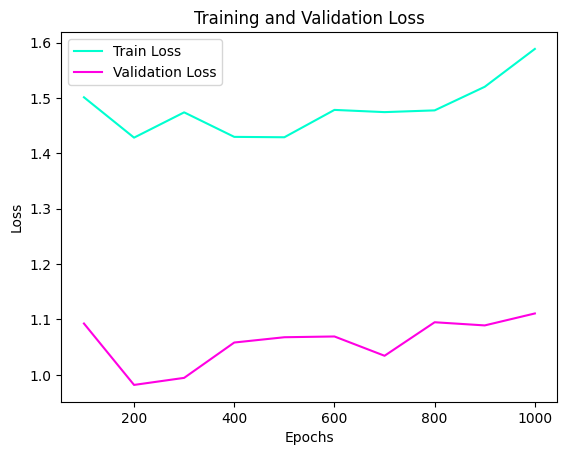

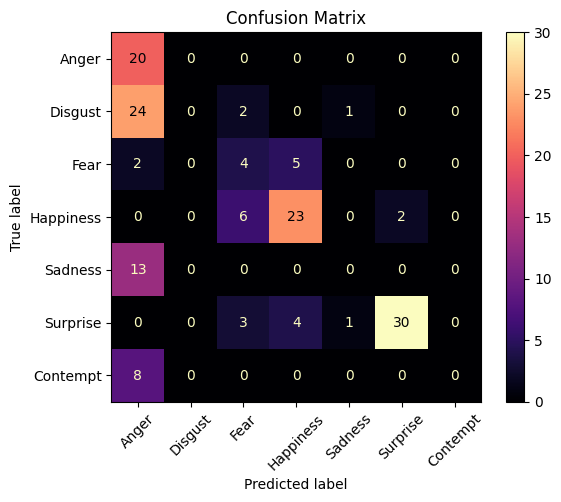

In [ ]:
# Train with optimal hyperparameters

epochs = 1000

# ----------------------------------------------------------------------------
# Enter optimal hyperparameters here
dropout_p = 0.2966277798229542
batch_size = 16
n_layers = 1
neuron_counts = [19]
lr = 0.006835733739791656
weight_decay = 0.022233599052813944 
# ----------------------------------------------------------------------------

input_dim = 25
output_dim = 7
layers = []
in_features = input_dim
for i in range(n_layers):
    out_features = neuron_counts[i]
    layers.append((in_features, out_features))
    in_features = out_features
            
layers.append((in_features, output_dim))

config = Config(dropout_p=dropout_p,
                    batch_size=batch_size,
                    lr=lr,
                    weight_decay=weight_decay)

trainloader, valloader, testloader = create_loaders(config.batch_size)
mlp = build_mlp(config, layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mlp.parameters(), lr=config.lr, weight_decay=config.weight_decay)
min_val_loss = train(mlp, epochs, trainloader, valloader, criterion, optimizer)
eval(mlp, testloader, criterion, optimizer)